In [1]:
import os
import cv2
import string
import numpy as np
# from tqdm import tqdm

from pickle import dump
from pickle import load

import tensorflow as tf

In [2]:
'GPU: ', tf.test.is_gpu_available()

('GPU: ', True)

In [3]:
MASTER_PATH = '../../Resources/models/image_captioning'
DATA_PATH = '../../Resources/data/image_captioning/Flickr_Data/Flickr_Data/'

MASTER_PATH, DATA_PATH

('../../Resources/models/image_captioning',
 '../../Resources/data/image_captioning/Flickr_Data/Flickr_Data/')

In [4]:
def extract_features(data_path):
    model = tf.keras.applications.vgg16.VGG16()
    model.layers.pop()
    model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print(model.summary())
    
    features = {}
    for f in os.listdir(data_path):
        filename = data_path + "/" + f
        image = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)  # this is (224, 224, 3)
        image = np.expand_dims(image, axis=0)
        image = tf.keras.applications.vgg16.preprocess_input(image)
        
        feature = model.predict(image)
        feature = np.reshape(feature, feature.shape[1])
        image_id = f.split(".")[0]
        features[image_id] = feature

    return features

In [5]:
if not os.path.exists(os.path.join(MASTER_PATH, 'features.pkl')):
    features = extract_features(os.path.join(DATA_PATH, 'Images')) 
    dump(features, open(os.path.join(MASTER_PATH, 'features.pkl'), 'wb')) 
    print(len(features))

In [6]:
def load_doc(filepath):
    with open(filepath, 'r') as f:
        text = f.read()
    return text

In [7]:
def load_descriptions(doc):
    
    ## Return dictionary of image_name: image_description
    
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(tokens) < 2:
            continue
        
        image_id = tokens[0].split('.')[0]
        image_desc = ' '.join(tokens[1:])
        
        if image_id not in mapping:
            mapping[image_id] = []
            mapping[image_id].append(image_desc)
            
    return mapping

In [8]:
doc = load_doc(os.path.join(DATA_PATH, 'Flickr_TextData/Flickr8k.token.txt'))
descriptions = load_descriptions(doc)
print('Loaded {} descriptions'.format(len(descriptions)))

Loaded 8092 descriptions


In [9]:
for k, v in descriptions.items():
    print(k, v)
    break

1000268201_693b08cb0e ['A child in a pink dress is climbing up a set of stairs in an entry way .']


In [10]:
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i, desc in enumerate(desc_list):
            desc = desc.split()
            desc = [w.lower() for w in desc]
            desc = [w.translate(table) for w in desc]
            desc = [w for w in desc if len(w) > 1]
            desc = [w for w in desc if w.isalpha()]
            descriptions[key][i] = ' '.join(desc)

In [11]:
def to_vocabulary(descriptions):
    words = set()
    for key in descriptions.keys():
        for d in descriptions[key]:
            words.update(d.split())
    return words

In [12]:
def save_descriptions(descriptions, output_filepath):
    with open(output_filepath, 'w') as ofp:
        for key,desc_list in descriptions.items():
            for d in desc_list:
                ofp.write(key + ' ' + d + '\n')

In [13]:
clean_descriptions(descriptions)
vocab = to_vocabulary(descriptions)
print(len(vocab))
save_descriptions(descriptions, os.path.join(MASTER_PATH, 'clean_descriptions.txt'))

4473


In [14]:
def load_identifiers(filepath):
    doc = load_doc(filepath)
    ids = set()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        ids.add(line.split('.')[0])
    return ids

In [15]:
def load_clean_descriptions(filepath, ids):
    doc = load_doc(filepath)
    descriptions = {}
    for line in doc.split('\n'):
        tokens = line.split()
        if len(tokens) < 1:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in ids:
            if image_id not in descriptions:
                descriptions[image_id] = []
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

In [16]:
def load_photo_features(filepath, ids):
    features = load(open(filepath, 'rb'))
    return {k:features[k] for k in ids}

In [17]:
train_ids = load_identifiers(os.path.join(DATA_PATH, 'Flickr_TextData/Flickr_8k.trainImages.txt'))
print(len(train_ids))
train_descriptions = load_clean_descriptions(os.path.join(MASTER_PATH, 'clean_descriptions.txt'), train_ids)
print(len(train_descriptions))
train_features = load_photo_features(os.path.join(MASTER_PATH, 'features.pkl'), train_ids)
print(len(train_features))

6000
6000
6000


In [18]:
def to_lines(descriptions):
    desc_list = []
    for key in descriptions:
        for d in descriptions[key]:
            desc_list.append(d)
    return desc_list

In [19]:
def create_tokenizer(descriptions):
    tok = tf.keras.preprocessing.text.Tokenizer()
    tok.fit_on_texts(to_lines(descriptions))
    
    return tok

In [20]:
tokenizer = create_tokenizer(train_descriptions)

In [21]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

3848


In [22]:
def data_generator(descriptions, photos, tokenizer, max_length, num_photos_per_batch):
    X1, X2, y = [], [], []
    n = 0
    
    while 1:
        for key, desc_list in descriptions.items():
            n += 1
            photo = photos[key]
            
            for desc in desc_list:
                seq = [tokenizer.word_index[word] for word in desc.split(' ') if word in tokenizer.word_index]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = [], [], []
                n = 0

In [23]:
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [24]:
maxlen = max_length(train_descriptions)
print(maxlen)

30


In [25]:
test_ids = load_identifiers(os.path.join(DATA_PATH, 'Flickr_TextData/Flickr_8k.devImages.txt'))
print('Test Ids: ', len(test_ids))

test_descriptions = load_clean_descriptions(os.path.join(MASTER_PATH, 'clean_descriptions.txt'), test_ids)
print('Test desc: ', len(test_descriptions))

test_features = load_photo_features(os.path.join(MASTER_PATH, 'features.pkl'), test_ids)
print(len(test_features))

Test Ids:  1000
Test desc:  1000
1000


In [26]:
def map_embeddings(embeddings_index, tokenizer=tokenizer, embedding_dim=300):
    embeddings_matrix = np.zeros((len(tokenizer.word_index)+1, embedding_dim), dtype='float32')
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector
    return embeddings_matrix

In [27]:
if not os.path.exists(os.path.join(MASTER_PATH, 'embeddings.npy')):
    embeddings_path = '../../Resources/glove.840B.300d.pkl'
    glove = np.load(embeddings_path, allow_pickle=True)

    embeddings = map_embeddings(glove)
    del glove
    np.save(os.path.join(MASTER_PATH, 'embeddings.npy'), embeddings)
else:
    embeddings = np.load(os.path.join(MASTER_PATH, 'embeddings.npy'))

In [28]:
def neural_net(vocab_size, maxlen):
    inputs1 = tf.keras.layers.Input(shape=(1000, ))
    fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
    fe2 = tf.keras.layers.Dense(256, activation='relu')(fe1)
    
    inputs2 = tf.keras.layers.Input(shape=(maxlen, ))
    se1 = tf.keras.layers.Embedding(vocab_size, 300, weights=[embeddings], mask_zero=True, trainable=False)(inputs2)
    se2 = tf.keras.layers.Dropout(0.5)(se1)
    se3 = tf.keras.layers.LSTM(256)(se2)
    
    decoder_1 = tf.keras.layers.add([fe2, se3])
    decoder_2 = tf.keras.layers.Dense(256, activation='relu')(decoder_1)
    
    outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder_2)
    
    model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam')
    
    print(model.summary())
#     plot_model(model, to_file='results/model.png', show_shapes=True)
    
    return model

In [29]:
model = neural_net(vocab_size, maxlen)
model_name = 'initial_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(MASTER_PATH, model_name), 
                            monitor='loss', 
                            verbose=True, 
                            save_best_only=True, 
                            mode='min')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 300)      1154400     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1000)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [30]:
epochs = 10
num_pictures_per_batch = 24
steps = len(train_descriptions) // num_pictures_per_batch
steps

250

In [ ]:
for i in range(epochs):
    print('Epoch ', i+1)
    generator = data_generator(train_descriptions, train_features, tokenizer, maxlen, num_pictures_per_batch)
    model.fit_generator(generator,
                        epochs=1,
                        shuffle=True,
                        steps_per_epoch=steps,
                        verbose=1,
                        callbacks=[checkpoint])

In [31]:
model = tf.keras.models.load_model(os.path.join(MASTER_PATH, 'initial_model.h5'))

In [32]:
def search(photo, tokenizer=tokenizer, maxlen=maxlen, model=model):
    in_text = 'startseq'
    for i in range(maxlen):
        sequence = [tokenizer.word_index[w] for w in in_text.split() if w in tokenizer.word_index]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=maxlen)
        preds = model.predict([photo, sequence], verbose=0)
        preds = np.argmax(preds)
        word = tokenizer.index_word[preds]
        in_text += ' ' + word
        if word == 'endseq':
            break
            
        final = in_text.split()
        final = final[1:-1]
        final = ' '.join(final)
    return final

In [33]:
def extract_test_feature(filename):
    model = tf.keras.applications.vgg16.VGG16()
    model.layers.pop()
    model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[-1].output)
    
    img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224)))
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    img = tf.keras.applications.vgg16.preprocess_input(img)
    
    feature = model.predict(img)
    return feature

In [34]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def caption():
    img_dir = os.path.join(DATA_PATH, 'Images')
    idx = random.randint(1, len(os.listdir(img_dir)))
    print('ID: ', idx)
    
    imagename = os.listdir(img_dir)[idx]
    print('Image: ', imagename)
    imagename = os.path.join(DATA_PATH, 'Images', imagename)
    
    img = Image.open(imagename)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    
    test_img = extract_test_feature(imagename)
    text = search(test_img)
    
    print('Generated caption: {}'.format(' '.join(text.split(' ')[1:-1]).upper()))

ID:  1872
Image:  2431723485_bc6b8e6418.jpg
Generated caption: BIKER ROUNDING BEND
Wall time: 3.34 s


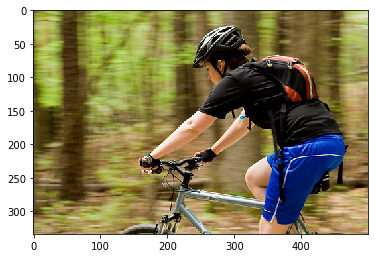

In [38]:
%%time
caption()